In [1]:
%matplotlib notebook

import numpy as np
import cv2
import os
import sys
import glob
import matplotlib.mlab as mlab
import matplotlib.image as mpimg

from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import TheilSenRegressor
from skimage.transform import radon, rescale
from scipy.stats import multivariate_normal
from scipy import stats

sys.path.append('../functions/')
sys.path.append('../utils/')

from DoG import DoG
from file_manager import File_manager
from wdd_decoder_functions import create_diff_images, filter_with_kernel, calc_accumulator, calc_angles, read_GT
from wdd_decoder_functions import read_DD, def_orientation, subst_angles

#Radian
radi = 180/np.pi

In [ ]:
############################ TEST ###########################################
#Angle
a = 60

#Null matrix
col = 50
row = 50
test = np.zeros(shape=(col, row))

#Covariance
test_cov = 120 * np.eye(2)
test_cov[1][1] = test_cov[1][1] /4
print('Covariance')
print(test_cov)

#Rotation Matrix for angle a
rot = np.array([[np.cos(a/radi), -np.sin(a/radi)],[np.sin(a/radi), np.cos(a/radi)]])
print('Rotation Matrix')
print(rot)
test_cov = np.transpose(rot) @ test_cov @ rot

#Building the covariance matrix nxn
for x in range(col):
    for y in range(row):
        test[y,x] = multivariate_normal.pdf([x, y], mean=(col/2, row/2), cov=test_cov)

#Plotting covariance matrix
# fig=plt.figure()
# fig.suptitle('Covariance Matrix')
# plt.imshow(test)
# plt.show

In [ ]:
###################################### TEST #############################################
moment = cv2.moments(test)

#Image covariance (central nomarlized moments)
img_cov = np.array([[moment['nu20'], moment['nu11']], [moment['nu11'], moment['nu02']]])
print('Image Covariance')
print(img_cov.astype(int))

#Eigenvalues
w, v = np.linalg.eig(img_cov)

#Eigenvalues
print('Eigenvalues w')
print(w)

#Normalized Eigenvectors
print('Eigenvectors v')
print(v)

#Angle first component
print('FIRST COMPONENT')
print('Angle in degrees (Cartesian)')
angleFC = np.arctan2(v[1][np.argmax(w)], v[0][np.argmax(w)])*radi;
print(angleFC)
print('Angle in degrees (Image)')
print(-angleFC)

#Angle second component
print('SECOND COMPONENT')
print('Angle in degrees (Cartesian)')
angleSC = np.arctan2(v[1][np.argmin(w)], v[0][np.argmin(w)])*radi;
print(angleSC)
print('Angle in degrees (Image)')
print(-np.arctan2(v[1][np.argmin(w)], v[0][np.argmin(w)])*radi)


In [ ]:
###################################### TEST #############################################
moment = cv2.moments(test)

#Image covariance (central nomarlized moments)
img_cov = np.array([[moment['nu20'], moment['nu11']], [moment['nu11'], moment['nu02']]])
print('Image Covariance')
print(img_cov.astype(int))

#Eigenvalues
w, v = np.linalg.eig(img_cov)

#Eigenvalues
print('Eigenvalues w')
print(w)

#Normalized Eigenvectors
print('Eigenvectors v')
print(v)

#Angle first component
print('FIRST COMPONENT')
print('Angle in degrees (Cartesian)')
angleFC = np.arctan2(v[1][np.argmax(w)], v[0][np.argmax(w)])*radi;
print(angleFC)
print('Angle in degrees (Image)')
print(-angleFC)

#Angle second component
print('SECOND COMPONENT')
print('Angle in degrees (Cartesian)')
angleSC = np.arctan2(v[1][np.argmin(w)], v[0][np.argmin(w)])*radi;
print(angleSC)
print('Angle in degrees (Image)')
print(-np.arctan2(v[1][np.argmin(w)], v[0][np.argmin(w)])*radi)


In [39]:
#Path to the dances and WR test
#With WDs
path = '../Data/WDs/'
pathWR = '20160814_1002_1/9'
#With NoWDs
pathNW = '../Data/NoWD/'
pathWRNW = '20160814_1017_1/0'
#Creates the difference images
diff_img = create_diff_images(path)
diff_imgNW = create_diff_images(pathNW)

<IPython.core.display.Javascript object>


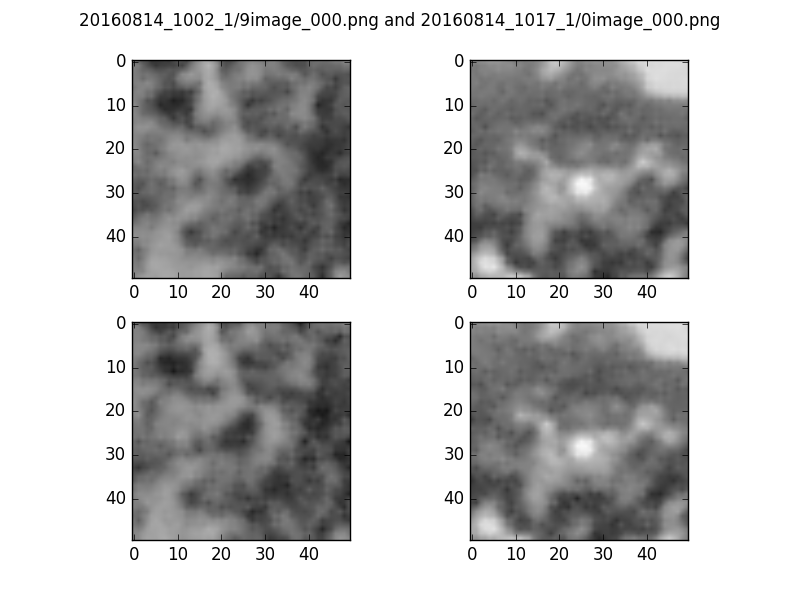

In [40]:
###################################### TEST #############################################
#Original image
fig1 = plt.figure()
fig1.suptitle(pathWR + 'image_000.png and ' + pathWRNW + 'image_000.png')
#Dance
plt.subplot(221)
plt.imshow(mpimg.imread(path + pathWR + '/image_034.png'))
plt.subplot(223)
plt.imshow(mpimg.imread(path + pathWR + '/image_035.png'))
#No Dance
plt.subplot(222)
plt.imshow(mpimg.imread(pathNW + pathWRNW + '/image_000.png'))
plt.subplot(224)
plt.imshow(mpimg.imread(pathNW + pathWRNW + '/image_001.png'))

<IPython.core.display.Javascript object>


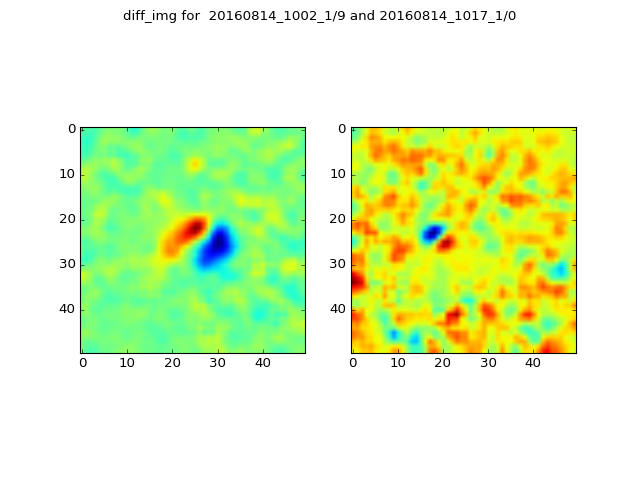

<function matplotlib.pyplot.show>

In [41]:
###################################### TEST #############################################
#Difference image
fig2 = plt.figure()
fig2.suptitle('diff_img for  ' + pathWR + ' and ' + pathWRNW)
#Dance
plt.subplot(121)
plt.imshow(diff_img[pathWR][34], cmap=plt.cm.jet)
#No Dance
plt.subplot(122)
plt.imshow(diff_imgNW[pathWRNW][0], cmap=plt.cm.jet)
plt.show

<IPython.core.display.Javascript object>


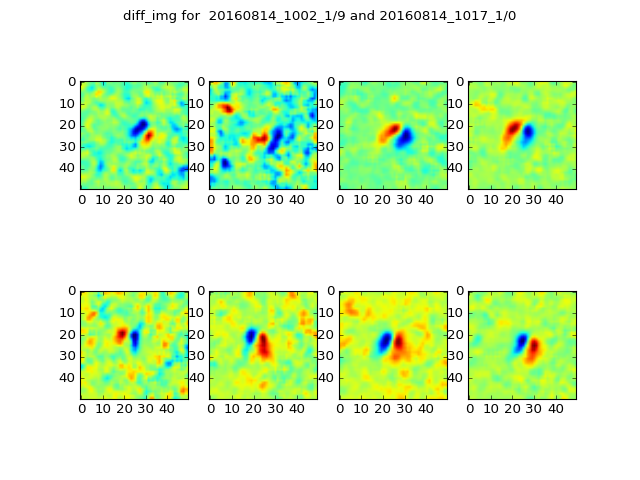

<function matplotlib.pyplot.show>

In [42]:
###################################### TEST #############################################
#Difference image
fig2 = plt.figure()
fig2.suptitle('diff_img for  ' + pathWR + ' and ' + pathWRNW)
#Dance
plt.subplot(241)
plt.imshow(diff_img[pathWR][32], cmap=plt.cm.jet)
#Dance
plt.subplot(242)
plt.imshow(diff_img[pathWR][33], cmap=plt.cm.jet)
#Dance
plt.subplot(243)
plt.imshow(diff_img[pathWR][34], cmap=plt.cm.jet)
#Dance
plt.subplot(244)
plt.imshow(diff_img[pathWR][35], cmap=plt.cm.jet)

#Dance
plt.subplot(245)
plt.imshow(diff_img[pathWR][36], cmap=plt.cm.jet)
#Dance
plt.subplot(246)
plt.imshow(diff_img[pathWR][37], cmap=plt.cm.jet)
#Dance
plt.subplot(247)
plt.imshow(diff_img[pathWR][38], cmap=plt.cm.jet)
#Dance
plt.subplot(248)
plt.imshow(diff_img[pathWR][39], cmap=plt.cm.jet)

plt.show

<IPython.core.display.Javascript object>


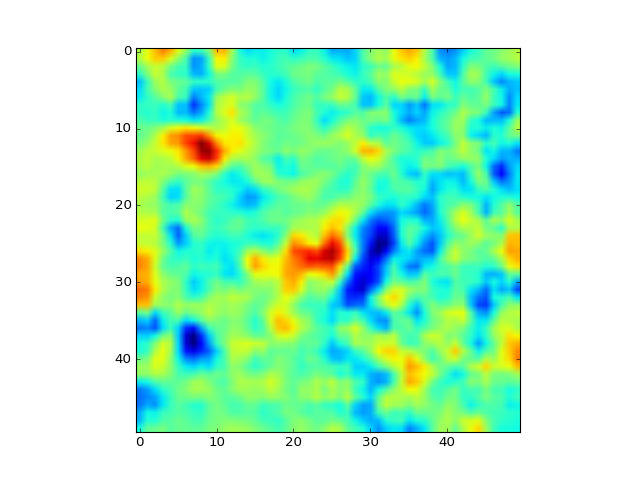

max = 25.2222222222
x = 8
y = 12
25.2222222222
min = -22.7777777778
x = 7
y = 38
-22.7777777778
26.0192236625


In [43]:
###################################### TEST #############################################
a=diff_img[pathWR][33]

fig2 = plt.figure()
plt.imshow(a, cmap=plt.cm.jet)


print('max = ' + str(a.max()))
print('x = ' + str(np.argmax(np.max(a, axis=0))))
print('y = ' + str(np.argmax(np.max(a, axis=1))))
print(a[np.argmax(np.max(a, axis=1)),np.argmax(np.max(a, axis=0))])

print('min = ' + str(a.min()))
print('x = ' + str(np.argmin(np.min(a, axis=0))))
print('y = ' + str(np.argmin(np.min(a, axis=1))))
print(a[np.argmin(np.min(a, axis=1)),np.argmin(np.min(a, axis=0))])

b=[np.argmax(np.max(a, axis=0))-np.argmin(np.min(a, axis=0)),np.argmax(np.max(a, axis=1))-np.argmin(np.min(a, axis=1))]
print(np.linalg.norm(b))

<IPython.core.display.Javascript object>


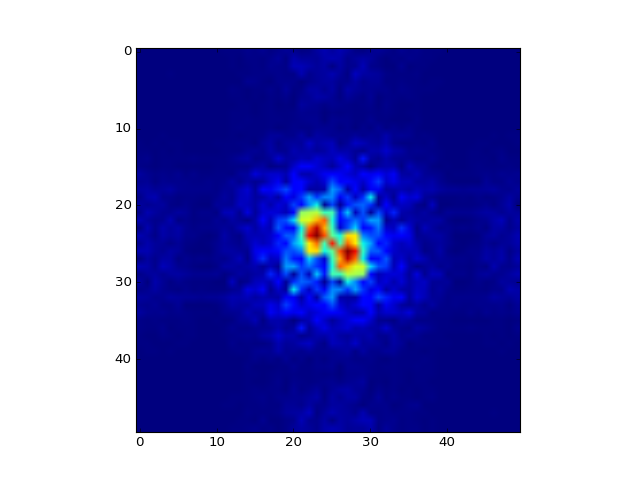

max = 4627.61184687
x = 27
y = 26
4627.61184687
3.60555127546


In [44]:
###################################### TEST #############################################
#Dance
a = np.fft.fftshift(abs(np.fft.fft2(diff_img[pathWR][34])))

fig2 = plt.figure()
plt.imshow(a, cmap=plt.cm.jet)

print('max = ' + str(a.max()))
print('x = ' + str(np.argmax(np.max(a, axis=0))))
print('y = ' + str(np.argmax(np.max(a, axis=1))))
print(a[np.argmax(np.max(a, axis=1)),np.argmax(np.max(a, axis=0))])

b=[np.argmax(np.max(a, axis=0))-24,np.argmax(np.max(a, axis=1))-24]
print(np.linalg.norm(b))

<IPython.core.display.Javascript object>


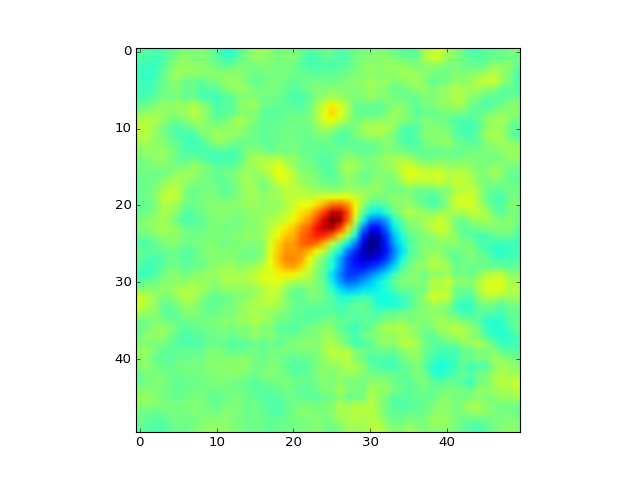

99

In [51]:
###################################### TEST #############################################
a=diff_img[pathWR][34]
#a=mpimg.imread(pathWR + '/image_035.png')

fig2 = plt.figure()
plt.imshow(a, cmap=plt.cm.jet)
len(diff_img[pathWR])

<IPython.core.display.Javascript object>


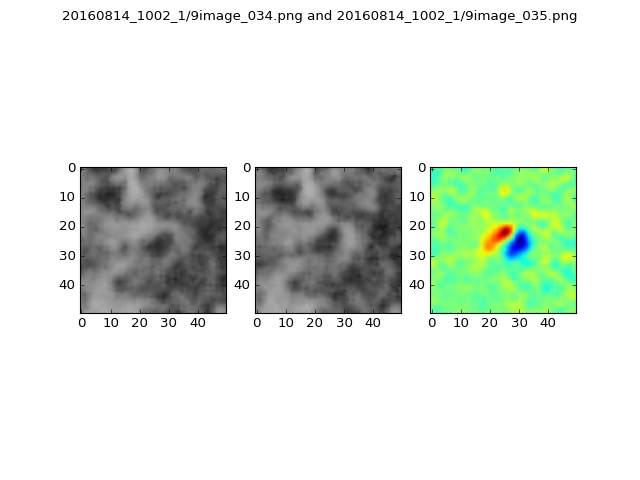

In [54]:
###################################### TEST #############################################
#Original image
fig1 = plt.figure()
fig1.suptitle(pathWR + 'image_034.png and ' + pathWR + 'image_035.png')
#Dance
plt.subplot(131)
plt.imshow(mpimg.imread(path + pathWR + '/image_034.png'))
plt.subplot(132)
plt.imshow(mpimg.imread(path + pathWR + '/image_035.png'))
plt.subplot(133)
plt.imshow(diff_img[pathWR][34], cmap=plt.cm.jet)


<IPython.core.display.Javascript object>


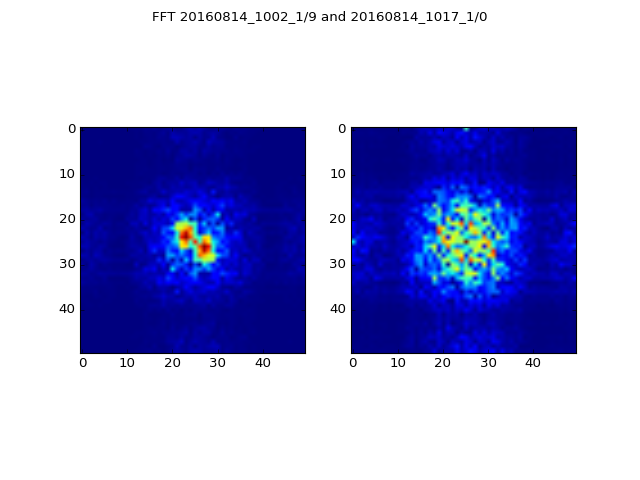

In [55]:
###################################### TEST #############################################
#Dance
tmpWR = np.fft.fftshift(abs(np.fft.fft2(diff_img[pathWR][34])))
#No Dance
tmpNW = np.fft.fftshift(abs(np.fft.fft2(diff_imgNW[pathWRNW][0])))

fig3 = plt.figure()
fig3.suptitle('FFT ' + pathWR + ' and ' + pathWRNW)
#Dance
plt.subplot(121)
plt.imshow(tmpWR, cmap=plt.cm.jet)
#No Dance
plt.subplot(122)
plt.imshow(tmpNW, cmap=plt.cm.jet)

In [56]:
#Dances
FDI = calc_accumulator(diff_img)
#No Dances
FDINW = calc_accumulator(diff_imgNW)

<IPython.core.display.Javascript object>


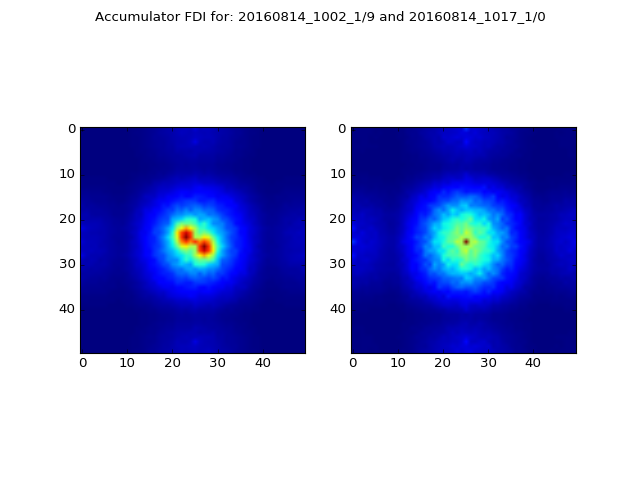

In [57]:
###################################### TEST #############################################
fig4 = plt.figure()
fig4.suptitle('Accumulator FDI for: ' + pathWR + ' and ' + pathWRNW)
#Dance
plt.subplot(121)
plt.imshow(FDI[pathWR], cmap=plt.cm.jet)
#No Dance
plt.subplot(122)
plt.imshow(FDINW[pathWRNW], cmap=plt.cm.jet)
plt.show()

In [59]:
###################################### TEST #############################################
#Dance
moment = cv2.moments(FDI[pathWR])
#Image covariance
img_cov = np.array([[moment['nu20'], moment['nu11']], [moment['nu11'], moment['nu02']]])
#Eigenvalues
w, v = np.linalg.eig(img_cov)
#Eigenvalues
print('Dance')
print('Eigenvalues w')
print(w)
#Normalized Eigenvectors
print('Eigenvectors v')
print(v)

print('--------------------------------------------------')
#No Dance
moment = cv2.moments(FDINW[pathWRNW])
#Image covariance
img_cov = np.array([[moment['nu20'], moment['nu11']], [moment['nu11'], moment['nu02']]])
#Eigenvalues
w, v = np.linalg.eig(img_cov)
#Eigenvalues
print('No Dance')
print('Eigenvalues w')
print(w)
#Normalized Eigenvectors
print('Eigenvectors v')
print(v)

Dance
Eigenvalues w
[  1.89678724e-06   1.91576480e-06]
Eigenvectors v
[[-0.72010361 -0.69386655]
 [ 0.69386655 -0.72010361]]
--------------------------------------------------
No Dance
Eigenvalues w
[  5.37935066e-06   5.24309577e-06]
Eigenvectors v
[[ 0.99857852 -0.05330046]
 [ 0.05330046  0.99857852]]


<IPython.core.display.Javascript object>


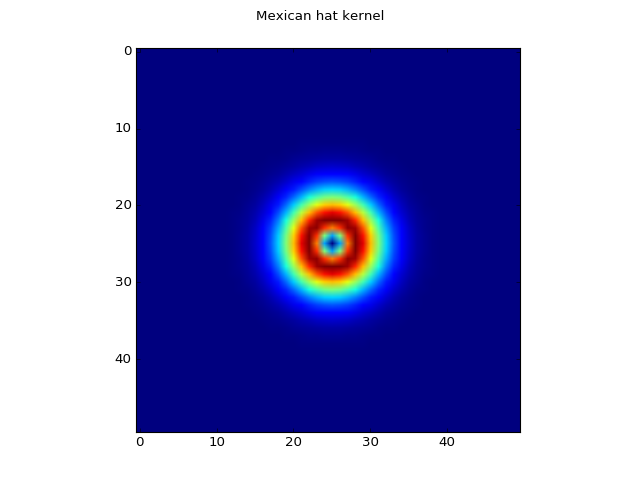

<function matplotlib.pyplot.show>

In [60]:
###################################### TEST ##########################################
dog = DoG().mexican_head_kernel

cov1 = 30 * np.eye(2)
cov2 = 4 * np.eye(2)

_dog = abs(np.fft.fftshift(np.fft.fft2(dog(50, [25,25], cov1, [25,25], cov2))))

fig5 = plt.figure()
fig5.suptitle('Mexican hat kernel')
plt.imshow(_dog, cmap=plt.cm.jet)
plt.show

In [62]:
#Dance
FDI_filt = filter_with_kernel(FDI)
#No Dance
FDI_filtNW = filter_with_kernel(FDINW)

<IPython.core.display.Javascript object>


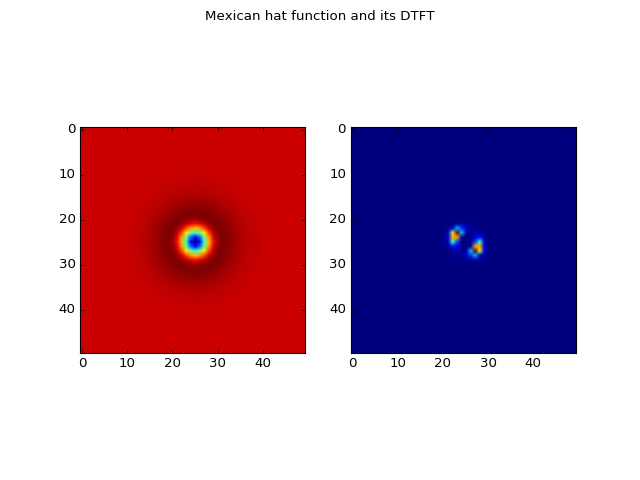

In [63]:
###################################### TEST #############################################
dog = DoG().mexican_head_kernel
cov1 = 30 * np.eye(2)
cov2 = 4 * np.eye(2)
Kern1 = dog(50, [25,25], cov1, [25,25], cov2)
Kern2 = abs(np.fft.fftshift(np.fft.fft2(Kern1)))

fig6 = plt.figure()
fig6.suptitle('Mexican hat function and its DTFT')
#Dance
plt.subplot(121)
plt.imshow(Kern1, cmap=plt.cm.jet)
#No Dance
plt.subplot(122)
plt.imshow(Kern2, cmap=plt.cm.jet)
plt.show()

<IPython.core.display.Javascript object>


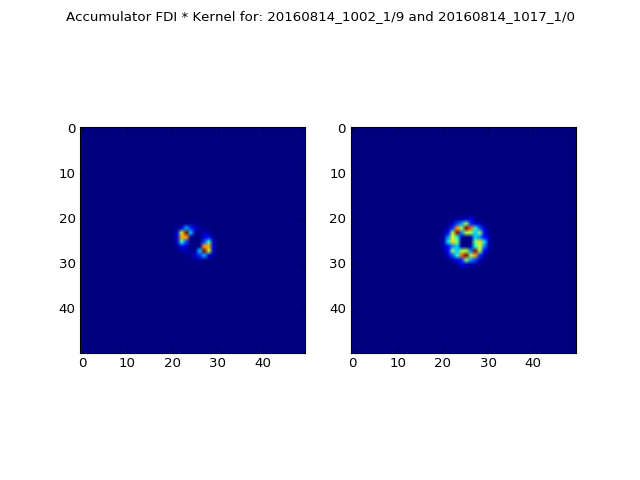

In [64]:
###################################### TEST #############################################
plt.imshow(FDI_filt[pathWR])
plt.show()

fig6 = plt.figure()
fig6.suptitle('Accumulator FDI * Kernel for: ' + pathWR + ' and ' + pathWRNW)
#Dance
plt.subplot(121)
plt.imshow(FDI_filt[pathWR], cmap=plt.cm.jet)
#No Dance
plt.subplot(122)
plt.imshow(FDI_filtNW[pathWRNW], cmap=plt.cm.jet)
plt.show()

In [ ]:
####################### TEST TO FILTER OUT FALSE POSITIVES ##################################
#Dance
moment = cv2.moments(FDI_filt[pathWR])
#Image covariance
img_cov = np.array([[moment['nu20'], moment['nu11']], [moment['nu11'], moment['nu02']]])
#Eigenvalues
w, v = np.linalg.eig(img_cov)
#Eigenvalues
print('Dance')
print('Eigenvalues w')
print(w)
#Normalized Eigenvectors
print('Eigenvectors v')
print(v)

print('--------------------------------------------------')
#No Dance
moment = cv2.moments(FDI_filtNW[pathWRNW])
#Image covariance
img_cov = np.array([[moment['nu20'], moment['nu11']], [moment['nu11'], moment['nu02']]])
#Eigenvalues
w, v = np.linalg.eig(img_cov)
#Eigenvalues
print('No Dance')
print('Eigenvalues w')
print(w)
#Normalized Eigenvectors
print('Eigenvectors v')
print(v)

In [ ]:
angles = calc_angles(FDI)
angles_filt = calc_angles(FDI_filt)

In [ ]:
#ReadGT
gt_angles = read_GT(path)
#ReadDD
dd_angles = read_DD(path)
#Orientation adjusted fft angles
adj_angles = def_orientation(angles, dd_angles)
#Orientation corrected fftfilt angles
adj_angles_filt = def_orientation(angles_filt, dd_angles)

In [ ]:
errDDAngle={}
errFFTAngle={}
errFilterAngle={}
for key, angle in list(angles.items()):
    errDDAngle[key] = subst_angles(dd_angles[key],gt_angles[key])
    errFFTAngle[key] = subst_angles(adj_angles[key],gt_angles[key])
    errFilterAngle[key] = subst_angles(adj_angles_filt[key],gt_angles[key])

In [ ]:
###################################### TEST #############################################
for key, angle in list(angles.items()):        
    print (key)
    print ('FFT Angle:             ' + str(angles[key]))
    print ('Filter Angle:          ' + str(angles_filt[key]))
    print ('GroundTruth Angle:     ' + str(gt_angles[key]))
    print ('DotDetector Angle:     ' + str(dd_angles[key]))    
    print ('FFTAngle - GTAngle:    ' + str(errFFTAngle[key]))    
    print ('FilterAngle - GTAngle: ' + str(errFilterAngle[key]))    
    print ('---------------------------------------------------')

In [ ]:
###################################### TEST #############################################
list_values = [v for v in errDDAngle.values()]

list_values = np.array(list_values)
list_values = list_values[np.logical_and(list_values>-150.0,list_values<150.0)]

mean=np.mean(list_values)
sigma=np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig6 = plt.figure()
plt.hist(list_values, bins=100, normed=True)

x = np.linspace(min(list_values), max(list_values), 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = ' + str(mean), xy=(-180, .022))
plt.annotate('std = ' + str(sigma), xy=(-180, .020))

plt.title("Histogram DotDetectorAngles")
plt.show()

In [ ]:
###################################### TEST #############################################
list_values = [v for v in errFFTAngle.values()]

mean=np.mean(list_values)
sigma=np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig7 = plt.figure()
plt.hist(list_values, bins=100, normed=True)

x = np.linspace(min(list_values), max(list_values), 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = ' + str(mean), xy=(-140, .025))
plt.annotate('std = ' + str(sigma), xy=(-140, .023))

plt.title("Histogram errFFTAngle")
plt.show()

In [ ]:
###################################### TEST #############################################
list_values = [v for v in errFilterAngle.values()]

mean = np.mean(list_values)
sigma = np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig8 = plt.figure()
plt.hist(list_values, bins=100, normed=True)

x = np.linspace(min(list_values), max(list_values), 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = ' + str(mean), xy=(-180, .06))
plt.annotate('std = ' + str(sigma), xy=(-180, .055))

plt.title("Histogram errFilterAngle")
plt.show()

In [ ]:
###################################### TEST #############################################
list_values = [v for v in errFilterAngle.values()]

list_values = np.array(list_values)
list_values = list_values[np.logical_and(list_values>-150.0,list_values<150.0)]

mean = np.mean(list_values)
sigma = np.std(list_values)

print('mean = ' + str(mean))
print('std = ' + str(sigma))

fig9 = plt.figure()
plt.hist(list_values, bins=50, normed=True)

x = np.linspace(min(list_values), max(list_values), 100)
plt.plot(x, mlab.normpdf(x, mean, sigma))

plt.annotate('mean = ' + str(mean), xy=(-24, .08))
plt.annotate('std = ' + str(sigma), xy=(-24, .075))

plt.title("Histogram errFilterAngle")
plt.show()

In [ ]:
#Sandbox
fig1 = plt.figure(dpi=300)
plt.imshow(FDI_filt[pathWR], cmap=plt.cm.jet)
plt.show()
# save figure
# Save the image in memory in PNG format
fig1.savefig('png7.png', format='png')